<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project - TheiaVision: Object Detection Technology for PMD Safety Alerts

> Authors: Ng Wei
---

**Problem Statement:**  
How can we enhance the safety of Personal Mobility Devices (PMDs) in urban environments by using object detection to improve PMD users' ability to perceive and respond to their surroundings?

**Target Audience:**
Management Team of PMD Maker

**Summary:**
This project aims to develop a object detection system to identifies obstacles such as pedestrians, vehicles, and traffic signs. By leveraging CNN algorithms YOLO model, this system would help Darren, a project manager, to lead the development of an alert system with object detection technology

There are a total of three notebooks for this project:  
 1. `01_EDA.ipynb`   
 2. `02_Modelling_Pytorch_SimpleCNN_SGTrafficSign.ipynb`   
 3. `03_Modelling_YOLOv8_labeled_SGTrafficSign.ipynb`
 4. `04_Merge_MultiDataset.ipynb`
 5. `05_Modelling_YOLOv8_combined_data.ipynb`
 6. `06_YOLOv8_Hyperparameter_Tuning.ipynb`

---
**This Notebook**
- We will look at the EDA of Singapore Traffic Sign data retrived from github.

# 1.1 Importing Libraries
This section of the code is responsible for importing the necessary libraries that will be used in the program.

In [1]:
import os
import numpy as np
import random as rdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageStat
import seaborn as sns
from IPython.display import HTML
import matplotlib.cm
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from skimage.color import rgb2gray

2024-05-10 03:42:28.426152: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-10 03:42:28.616193: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 03:42:29.519069: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 1.2 Assigning file path

This section of the code is responsible to specify the file path of Singapore Traffic Sign image data, each train and test data.

In [2]:
base_dir = ''
base_img_folder = '../data/singapore_traffic_sign'
train_img_folder = 'TRAIN'
test_img_folder = 'TEST'

dataset_dir = os.path.join(base_dir, base_img_folder)
train_dir = os.path.join(dataset_dir, train_img_folder)
test_dir = os.path.join(dataset_dir, test_img_folder)

print('Directory of train dataset: {}'.format(train_dir))
print('\nDirectory of test dataset: {}'.format(test_dir))

Directory of train dataset: ../data/singapore_traffic_sign/TRAIN

Directory of test dataset: ../data/singapore_traffic_sign/TEST


# 1.3 EDA

## 1.3.1 Check unique class in this dataset 
This Python code block is used to list and count the number of traffic sign classes in a training directory.

In [3]:
class_list = os.listdir(train_dir)

class_list = [item for item in class_list if item != '.DS_Store']

print('Total Number of traffic sign classes: {}'.format(len(class_list)))
print(class_list)

Total Number of traffic sign classes: 7
['2', '4', '7', '1', '6', '3', '5']


- This dataset consist of 7 different classes. Let's find out what these classes are.
---

## 1.3.2 Classes in the dataset
Below code will check `labels.txt` file for the classification description. 

In [4]:
label_manifest = pd.read_csv(os.path.join(base_dir, base_img_folder, 'labels.txt'))
label_manifest.loc[:,'INDEX'] = label_manifest.loc[:,'INDEX'].astype(str)
label_manifest.set_index('INDEX', inplace=True)
label_manifest.sample(7)

/tmp/ipykernel_812205/4049866409.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1' '2' '3' '4' '5' '6' '7']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  label_manifest.loc[:,'INDEX'] = label_manifest.loc[:,'INDEX'].astype(str)


,DESCRIPTION
INDEX,
1,PROHIBITORY_NO_JAYWALKING
6,INFO_PEDESTRIAN_USE_CROSSING
2,MANDATORY_STOP
5,PROHIBITORY_NO_ENTRY
4,INFO_ZEBRA_CROSSING
7,WARNING_CURVE_LEFT_ALIGNMENT_MARKER
3,WARNING_CURVE_RIGHT_ALIGNMENT_MARKER


- Above table show the class number and corresponding name.
---

## 1.3.3 Porportion of Dataset
Below code will check the number of image in each classification

In [5]:
def get_brightness(img_fn):
   im = Image.open(img_fn).convert('L') # convert to grayscale
   stat = ImageStat.Stat(im)
   return stat.mean[0]

def load_dataset(target_dir):
    img_list = [] # numpy array representation of image data
    label_list = [] # label corresponding to image

    traffic_signs_dict = { 
        'img_index': [],
        'label': [], # numerical label given to image
        'description': [], # essentially the name of the traffic sign
        'img_filename' : [], # filename given to this image
        'img_height': [], # height of image in pixels
        'img_width': [], # width of image in pixels
        'img_channels': [], # number of colour channels
        'img_aspect_ratio': [], # aspect ratio of image, taking height divided by width
        'img_brightness': []
    }

    #class_list_v2 = ['21']
    img_counter = 0

    for index_str in class_list:
        current_traffic_sign_dir = os.path.join(target_dir, index_str)
        if os.path.isdir(current_traffic_sign_dir):
            traffic_signs_img_list = os.listdir(current_traffic_sign_dir)
            for img_fn in traffic_signs_img_list:
                if img_fn.endswith('.jpg'):
                    current_traffic_sign = np.asarray(Image.open(os.path.join(current_traffic_sign_dir, img_fn)))
                    height, width, channels = current_traffic_sign.shape
                    img_list.append(current_traffic_sign)
                    label_list.append(index_str)
                    traffic_signs_dict['img_index'].append(img_counter)
                    traffic_signs_dict['img_filename'].append(os.path.join(current_traffic_sign_dir, img_fn))
                    traffic_signs_dict['img_height'].append(height)
                    traffic_signs_dict['img_width'].append(width)
                    traffic_signs_dict['img_channels'].append(channels)
                    traffic_signs_dict['img_aspect_ratio'].append(float(height) / float(width))
                    traffic_signs_dict['img_brightness'].append(get_brightness(os.path.join(current_traffic_sign_dir, img_fn)))
                    traffic_signs_dict['label'].append(int(index_str))
                    traffic_signs_dict['description'].append(label_manifest.loc[index_str,'DESCRIPTION'])

                    img_counter += 1
                #else:
                #    print('Skipping {}'.format(img_fn)) # print out skipped files for investigation
            print('{} images found for label [{}]: {}'.format(len(traffic_signs_img_list), index_str, label_manifest.loc[index_str,'DESCRIPTION']))
        else:
            print('Skipping {}'.format(current_traffic_sign_dir))
    
    result_df = pd.DataFrame(data=traffic_signs_dict).sort_values(by='label').reset_index(drop=True)
    return img_list, label_list, result_df

In [6]:
ts_img_list, ts_label_list, traffic_signs_df = load_dataset(train_dir)

86 images found for label [2]: MANDATORY_STOP
171 images found for label [4]: INFO_ZEBRA_CROSSING
48 images found for label [7]: WARNING_CURVE_LEFT_ALIGNMENT_MARKER
213 images found for label [1]: PROHIBITORY_NO_JAYWALKING
147 images found for label [6]: INFO_PEDESTRIAN_USE_CROSSING
65 images found for label [3]: WARNING_CURVE_RIGHT_ALIGNMENT_MARKER
121 images found for label [5]: PROHIBITORY_NO_ENTRY


- Above values show each count of images for different class.
---

## 1.3.4 Data Overview
Below section about to see how does the dataset looks like, what are the image class, resolution, colors, etc.

In [7]:
sample_traffic_signs = traffic_signs_df.sample(n=15)
sample_traffic_signs

,img_index,label,description,img_filename,img_height,img_width,img_channels,img_aspect_ratio,img_brightness
289,9,2,MANDATORY_STOP,../data/singapore_traffic_sign/TRAIN/2/3258.jpg,141,141,3,1.0,121.882350
482,117,4,INFO_ZEBRA_CROSSING,../data/singapore_traffic_sign/TRAIN/4/3547.jpg,90,90,3,1.0,77.912346
167,431,1,PROHIBITORY_NO_JAYWALKING,../data/singapore_traffic_sign/TRAIN/1/3391.jpg,224,224,3,1.0,101.586635
835,296,7,WARNING_CURVE_LEFT_ALIGNMENT_MARKER,../data/singapore_traffic_sign/TRAIN/7/2020.jpg,296,296,3,1.0,86.970097
332,729,3,WARNING_CURVE_RIGHT_ALIGNMENT_MARKER,../data/singapore_traffic_sign/TRAIN/3/3890.jpg,204,204,3,1.0,80.611351
357,704,3,WARNING_CURVE_RIGHT_ALIGNMENT_MARKER,../data/singapore_traffic_sign/TRAIN/3/4864.jpg,224,224,3,1.0,99.420799
741,632,6,INFO_PEDESTRIAN_USE_CROSSING,../data/singapore_traffic_sign/TRAIN/6/3740.jpg,188,188,3,1.0,106.849876
818,262,7,WARNING_CURVE_LEFT_ALIGNMENT_MARKER,../data/singapore_traffic_sign/TRAIN/7/0723.jpg,134,134,3,1.0,109.009301
272,51,2,MANDATORY_STOP,../data/singapore_traffic_sign/TRAIN/2/1411.jpg,123,123,3,1.0,116.573997
646,774,5,PROHIBITORY_NO_ENTRY,../data/singapore_traffic_sign/TRAIN/5/3132.jpg,294,294,3,1.0,106.503170


-Visualize the proportion of class in this dataset with the below

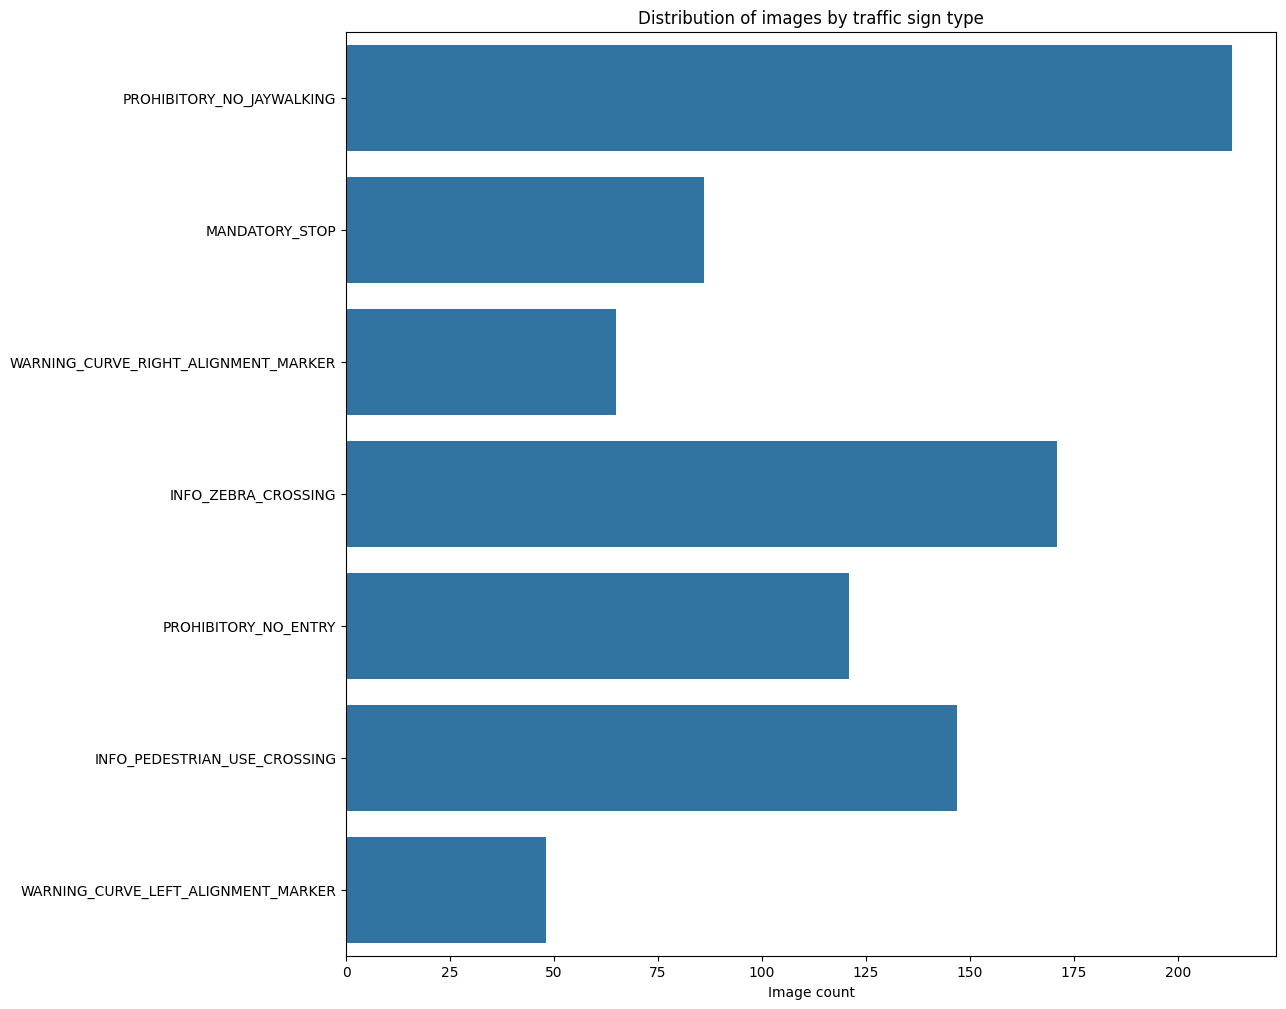

In [8]:
plt.figure(figsize=(12,12))
sns.countplot(data=traffic_signs_df, y='description')
plt.title('Distribution of images by traffic sign type')
plt.ylabel('')
plt.xlabel('Image count')
plt.show()

- Now we can see the proportion of dataset. `No Jaywalking Sign` seem to have the highest counts while `Curve Left Alignment` has the lowest counts in the dataset

---

## 1.3.5 Image Resolution 
This section will show the distribution of the image's resolution, how clear or blur are our images.

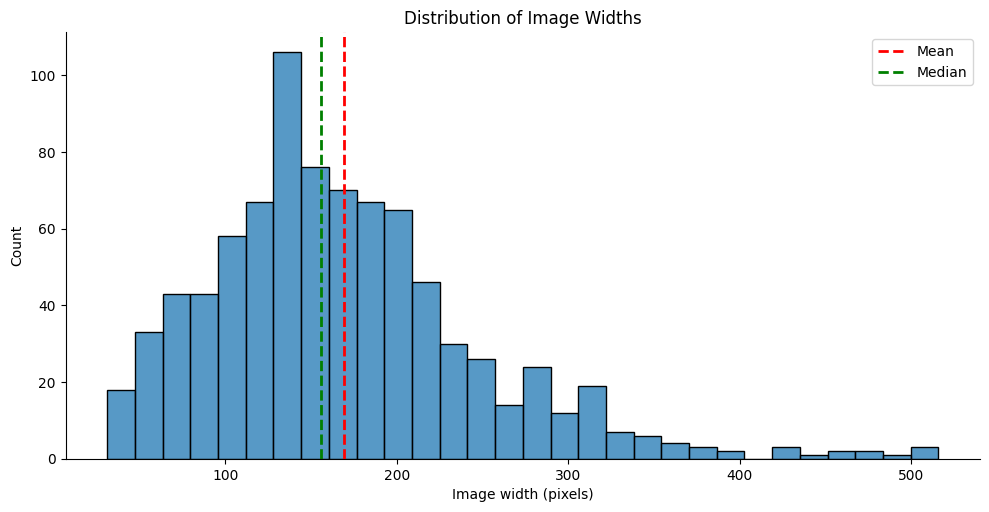

In [9]:
sns.displot(data=traffic_signs_df, x='img_width', height=5, aspect=2.0, bins=30)
plt.axvline(traffic_signs_df.loc[:,'img_width'].mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(traffic_signs_df.loc[:,'img_width'].median(), color='green', linestyle='dashed', linewidth=2, label='Median')
plt.title('Distribution of Image Widths')
plt.xlabel('Image width (pixels)')
plt.legend()
plt.show()

From the histogram above, we can observe that the image resolution have about ~150pixels, images are considered low resolution

Below code is to find out which image have the highest pixels counts.

In [10]:
largest_img = traffic_signs_df.loc[traffic_signs_df.loc[:,'img_width']==traffic_signs_df.loc[:,'img_width'].max(),:]
largest_img

,img_index,label,description,img_filename,img_height,img_width,img_channels,img_aspect_ratio,img_brightness
810,269,7,WARNING_CURVE_LEFT_ALIGNMENT_MARKER,../data/singapore_traffic_sign/TRAIN/7/5834.jpg,516,516,3,1.0,91.339872


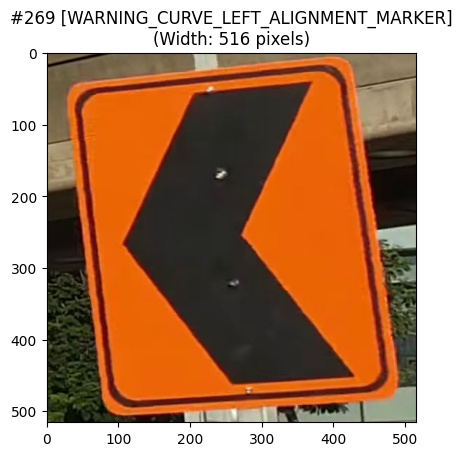

In [11]:
plt.imshow(ts_img_list[largest_img.iloc[0]['img_index']])
plt.title('#{} [{}]\n(Width: {} pixels)'.format(
    largest_img.iloc[0]['img_index'], 
    largest_img.iloc[0]['description'],
    largest_img.iloc[0]['img_width']
))
plt.show()

Below is to find the smallest image in the dataset.

In [12]:
smallest_img = traffic_signs_df.loc[traffic_signs_df.loc[:,'img_width']==traffic_signs_df.loc[:,'img_width'].min(),:]
smallest_img

,img_index,label,description,img_filename,img_height,img_width,img_channels,img_aspect_ratio,img_brightness
557,846,5,PROHIBITORY_NO_ENTRY,../data/singapore_traffic_sign/TRAIN/5/1079.jpg,31,31,3,1.0,81.17898


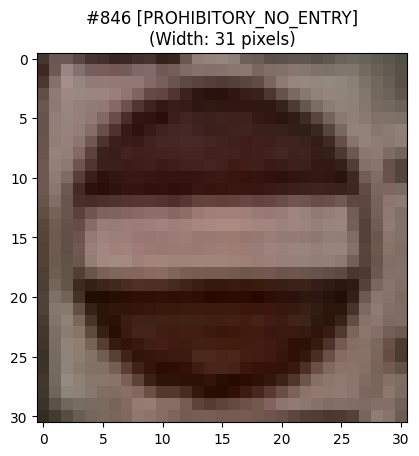

In [13]:
image_data = Image.open(smallest_img.iloc[0]['img_filename'])
plt.imshow(image_data)
plt.title('#{} [{}]\n(Width: {} pixels)'.format(
    smallest_img.iloc[0]['img_index'], 
    smallest_img.iloc[0]['description'],
    smallest_img.iloc[0]['img_width']
))
plt.show()


- We know now we have highest pixel count with 516 pixels and lowest 31 pixels in the dataset.
---

## 1.3.6 Image Brightness 
This section will show the distribution of the image's brightness, how bright or dim are our images.

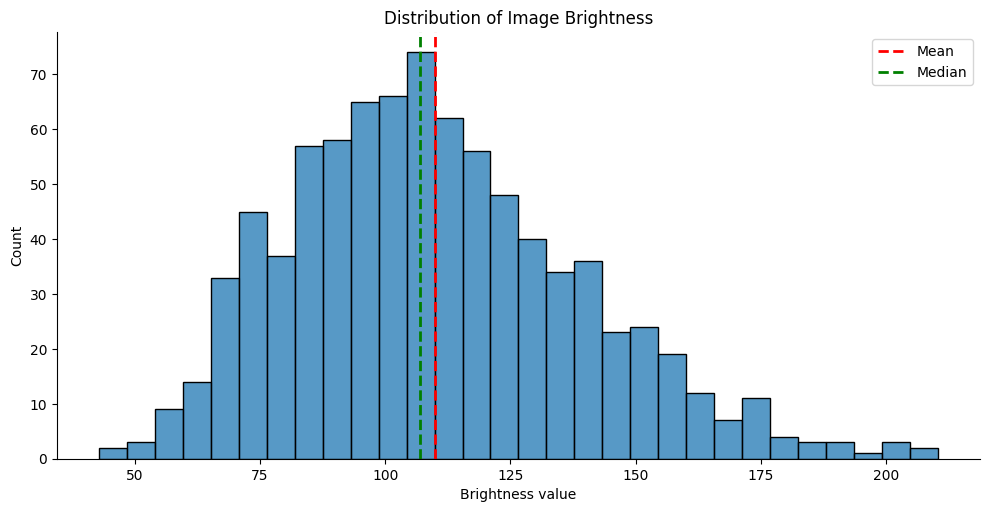

In [14]:
#plt.figure(figsize=(12, 12))
sns.displot(data=traffic_signs_df, x='img_brightness', height=5, aspect=2.0, bins=30)
plt.axvline(traffic_signs_df.loc[:,'img_brightness'].mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(traffic_signs_df.loc[:,'img_brightness'].median(), color='green', linestyle='dashed', linewidth=2, label='Median')
plt.title('Distribution of Image Brightness')
plt.xlabel('Brightness value')
plt.legend()
plt.show()

From the histogram above, we can observe that the image brightness have about ~110, images are considered low brightness
Note that the brightness level is from 0 to 255, 0 means absolute black and 255 means white

In [15]:
brightest_img = traffic_signs_df.loc[ \
    traffic_signs_df.loc[:,'img_brightness'] == traffic_signs_df.loc[:,'img_brightness'].max(), \
    : ]
brightest_img

,img_index,label,description,img_filename,img_height,img_width,img_channels,img_aspect_ratio,img_brightness
767,605,6,INFO_PEDESTRIAN_USE_CROSSING,../data/singapore_traffic_sign/TRAIN/6/5684.jpg,212,212,3,1.0,210.333526


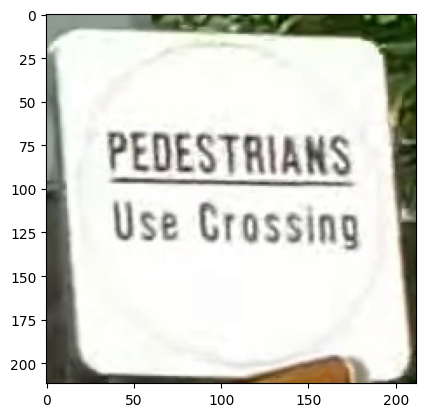

In [16]:
plt.imshow(Image.open(brightest_img.iloc[0]['img_filename']))


In [17]:
darkest_img = traffic_signs_df.loc[ \
    traffic_signs_df.loc[:,'img_brightness'] == traffic_signs_df.loc[:,'img_brightness'].min(), \
    : ]
darkest_img

,img_index,label,description,img_filename,img_height,img_width,img_channels,img_aspect_ratio,img_brightness
318,676,3,WARNING_CURVE_RIGHT_ALIGNMENT_MARKER,../data/singapore_traffic_sign/TRAIN/3/1053.jpg,60,60,3,1.0,42.8525


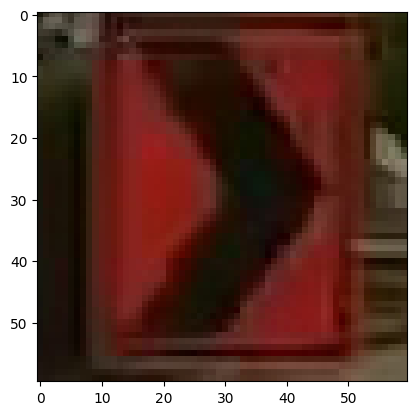

In [18]:
plt.imshow(Image.open(darkest_img.iloc[0]['img_filename']))


- The above code blocks are used to find which is the brightest and darkest image in the dataset.
---

## 1.3.7 Image RGB Distribution 
This section will show the distribution of the image's RGB value for each class.

In [19]:
def generate_average_image(image_array_list):
    # get total number of images present in list
    img_count = len(image_array_list)
    
    # initialize 3-channel array of floats that would hold data for average image
    arr=np.zeros((50,50,3),np.float) 
    
    # iterate through every image in the image-list
    for img in image_array_list: 
        # get back PIL image from the 3-channel array
        im = Image.fromarray(img.astype('uint8'), 'RGB')
        
        # force resize to 50x50 pixels, regardless of original image dimensions
        im_resize = im.resize((50, 50))
        
        # Contribute 1/img_count pixel intensity to produce average image
        arr = arr + (np.asarray(im_resize, np.float) / img_count) 
    
    # Round and convert float back to integer
    arr=np.array(np.round(arr),dtype=np.uint8)
    
    # return the average image and image count
    return arr, img_count

In [20]:
ts_test_img_list, ts_test_label_list, test_traffic_signs_df = load_dataset(test_dir)

15 images found for label [2]: MANDATORY_STOP
13 images found for label [4]: INFO_ZEBRA_CROSSING
10 images found for label [7]: WARNING_CURVE_LEFT_ALIGNMENT_MARKER
11 images found for label [1]: PROHIBITORY_NO_JAYWALKING
12 images found for label [6]: INFO_PEDESTRIAN_USE_CROSSING
12 images found for label [3]: WARNING_CURVE_RIGHT_ALIGNMENT_MARKER
14 images found for label [5]: PROHIBITORY_NO_ENTRY


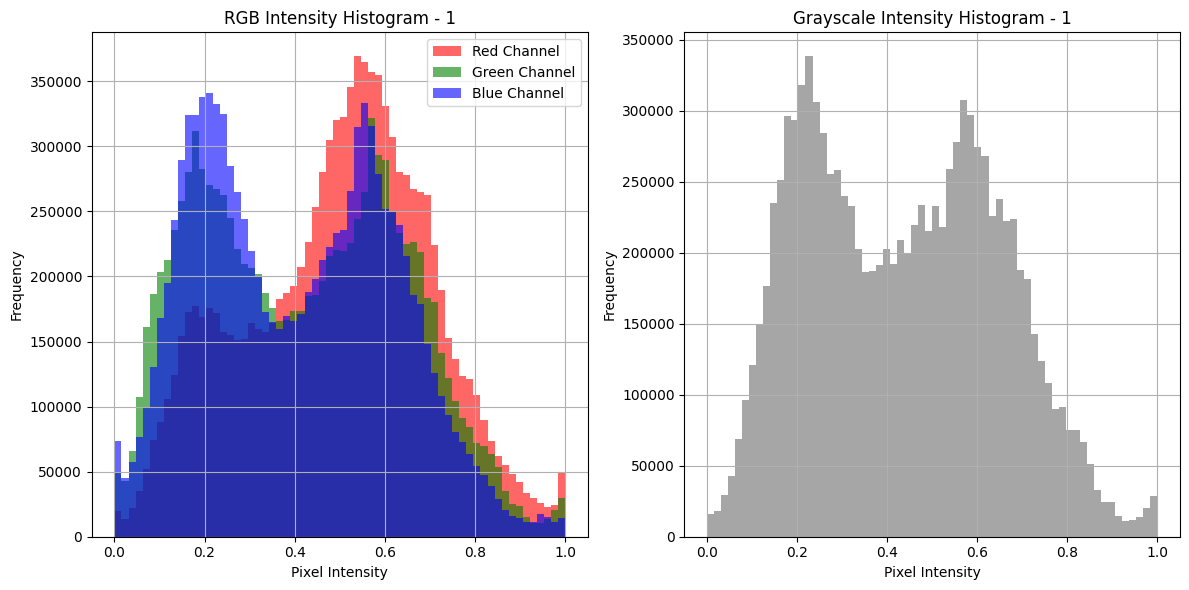

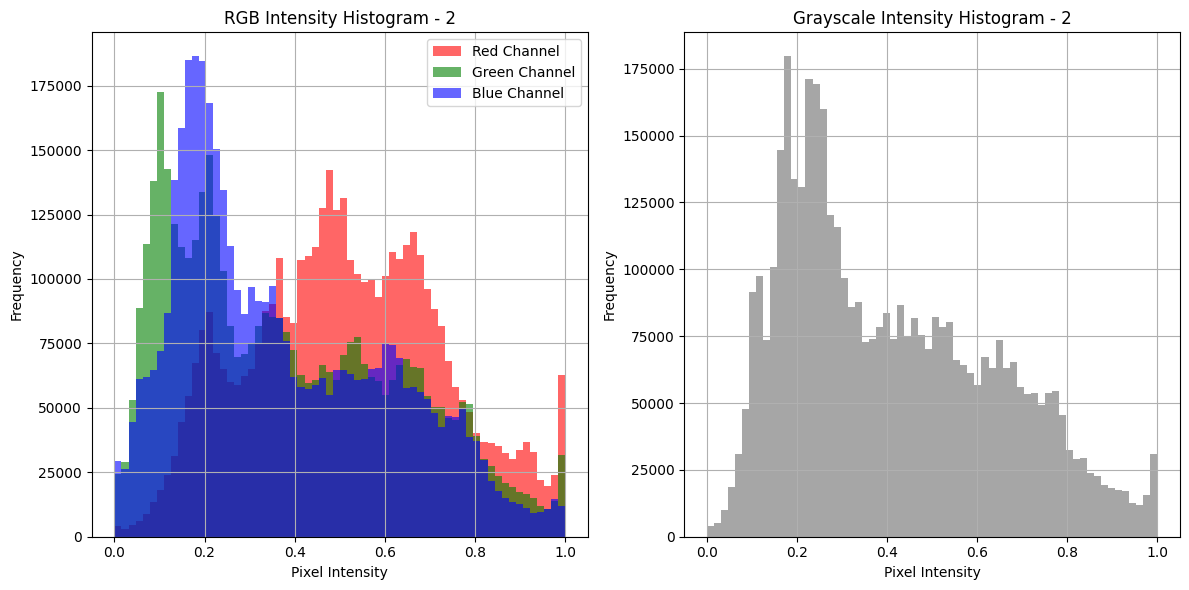

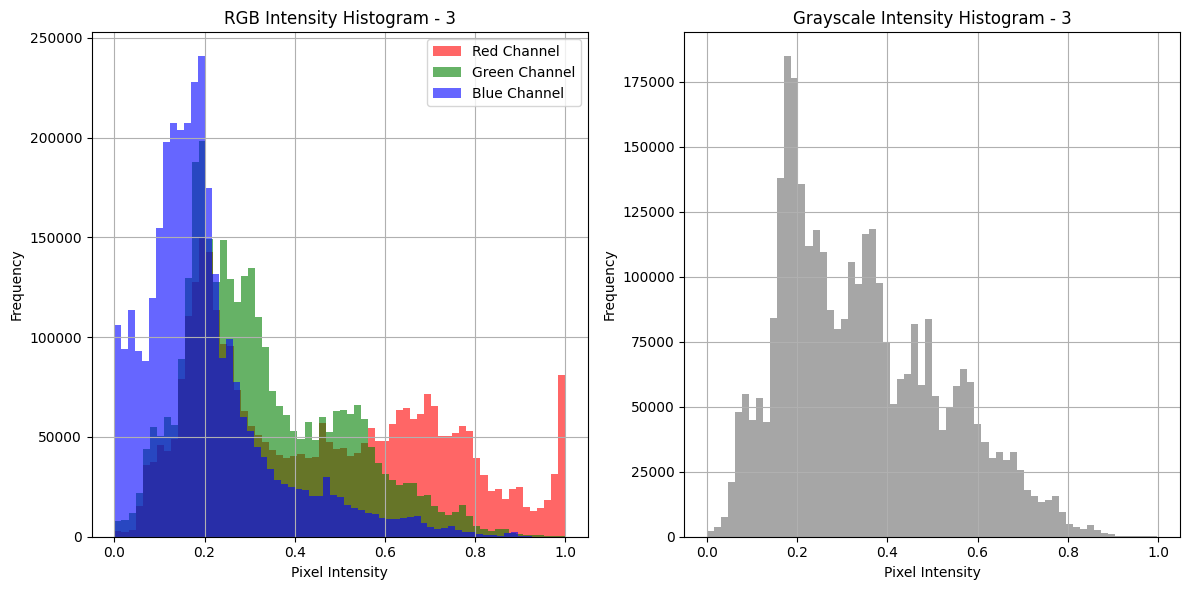

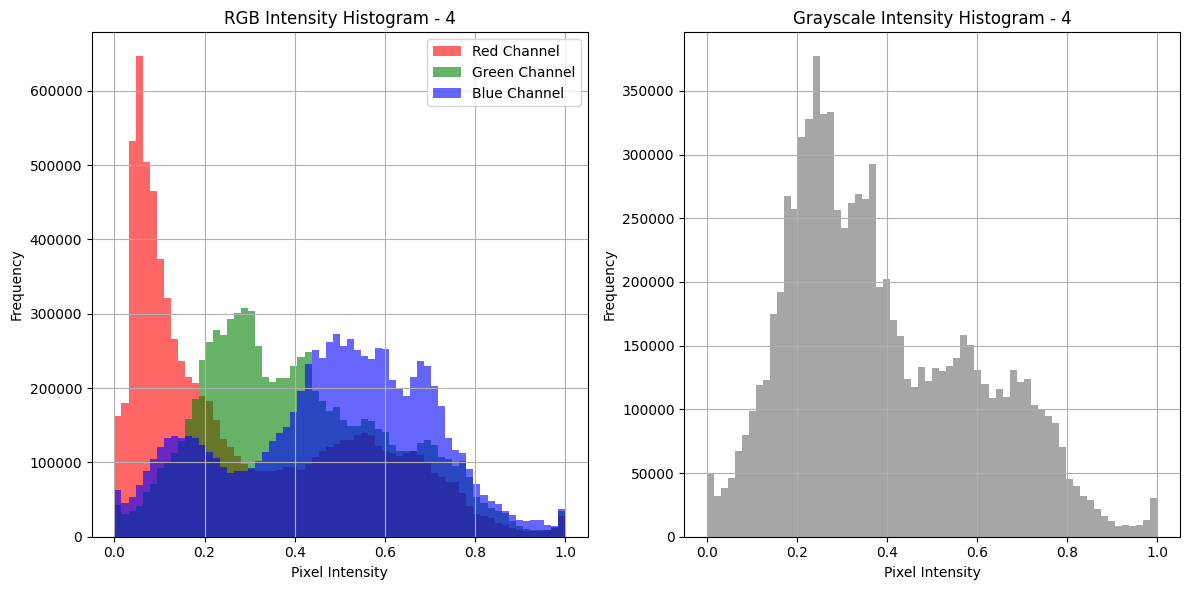

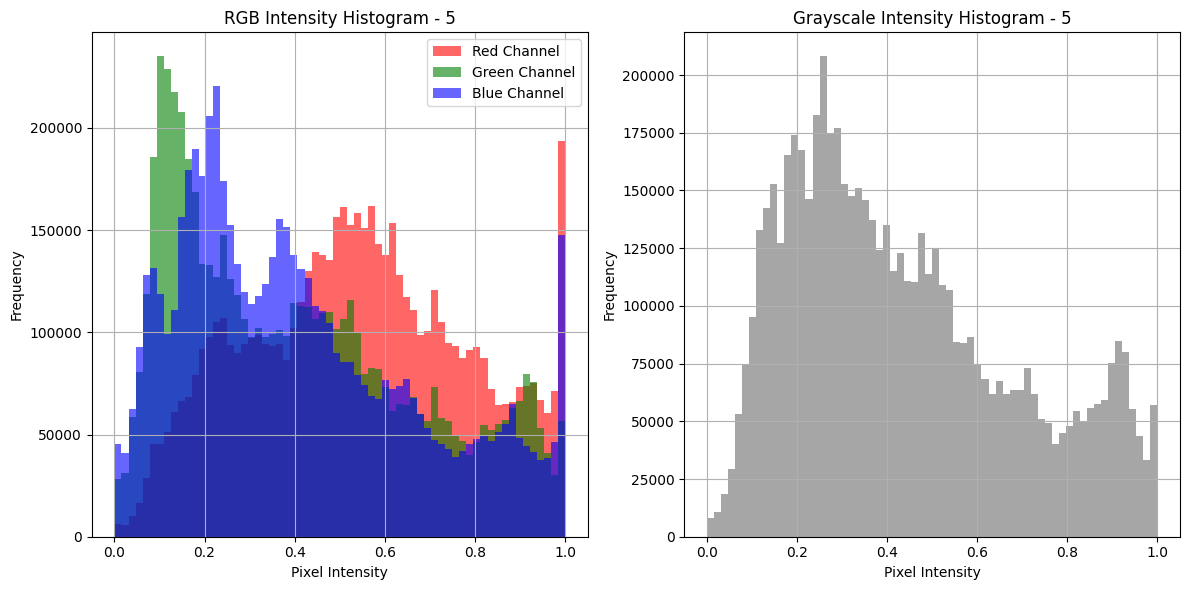

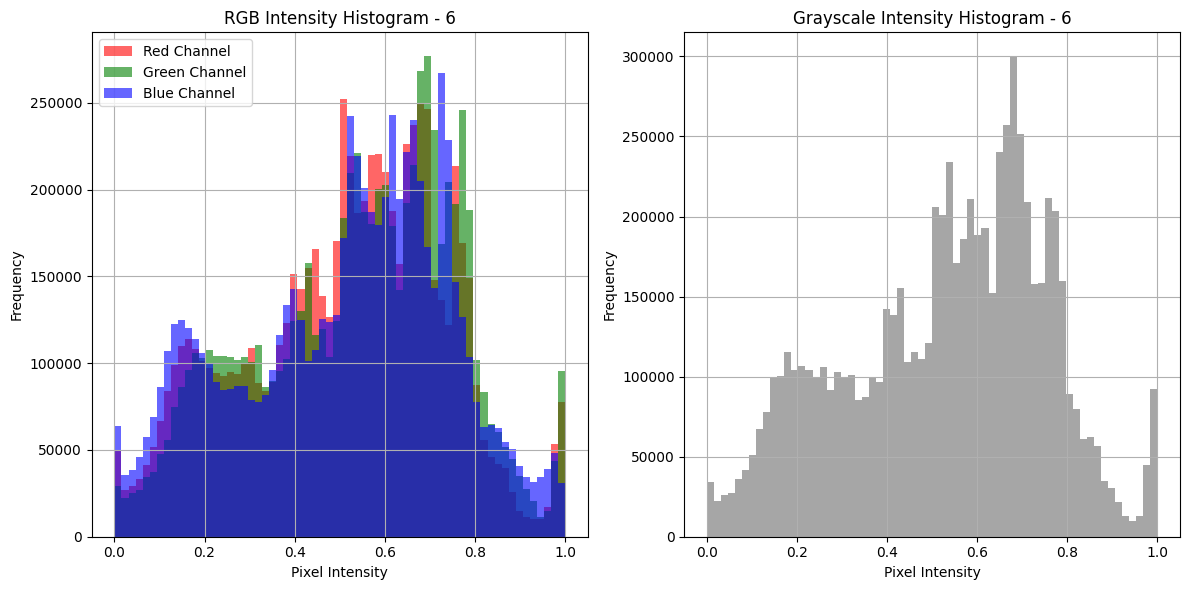

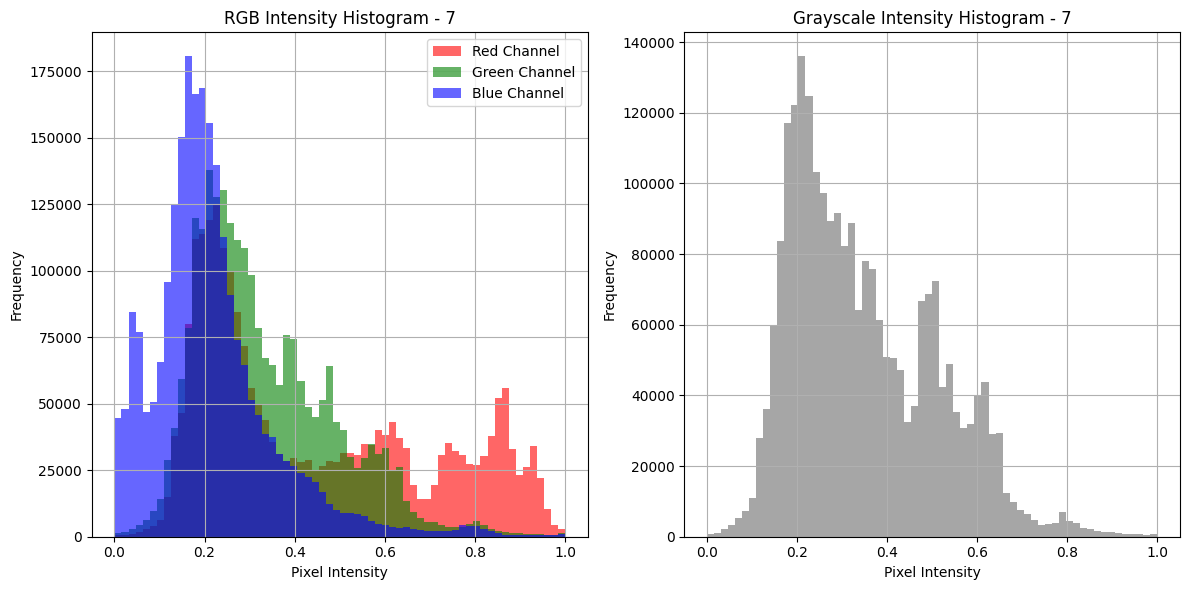

In [21]:
# Define constants
test_dir = '../data/singapore_traffic_sign/TRAIN'  # Adjust this path to your dataset
classes = ['1', '2','3','4','5','6','7']  # Ensure these match the folder names exactly
image_size = (224, 224)  # Define your image size (width, height)

def process_class_images(class_dir):
    # Initialize an array to store all pixel values for RGB and grayscale histograms
    all_pixels_rgb = np.array([])
    all_pixels_gray = np.array([])
    
    # Load images
    for file in os.listdir(class_dir):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(class_dir, file)
            img = load_img(img_path, target_size=image_size, color_mode='rgb')
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            img_array_flat = img_array.reshape(-1, 3)
            
            # Append pixel values for RGB histogram
            all_pixels_rgb = np.concatenate([all_pixels_rgb, img_array_flat], axis=0) if all_pixels_rgb.size else img_array_flat
            
            # Convert to grayscale and append pixel values for grayscale histogram
            gray_img = rgb2gray(img_array)
            all_pixels_gray = np.concatenate([all_pixels_gray, gray_img.flatten()], axis=0) if all_pixels_gray.size else gray_img.flatten()

    return all_pixels_rgb, all_pixels_gray

# Plot histograms
def plot_histograms(class_name, pixels_rgb, pixels_gray):
    plt.figure(figsize=(12, 6))
    
    # RGB Histogram
    plt.subplot(1, 2, 1)
    plt.hist(pixels_rgb[:, 0], bins=64, color='red', alpha=0.6, label='Red Channel')
    plt.hist(pixels_rgb[:, 1], bins=64, color='green', alpha=0.6, label='Green Channel')
    plt.hist(pixels_rgb[:, 2], bins=64, color='blue', alpha=0.6, label='Blue Channel')
    plt.title(f'RGB Intensity Histogram - {class_name}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    
    # Grayscale Histogram
    plt.subplot(1, 2, 2)
    plt.hist(pixels_gray, bins=64, color='gray', alpha=0.7)
    plt.title(f'Grayscale Intensity Histogram - {class_name}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Process each class and display results
for class_name in classes:
    class_dir = os.path.join(test_dir, class_name)
    pixels_rgb, pixels_gray = process_class_images(class_dir)
    plot_histograms(class_name, pixels_rgb, pixels_gray)

In [22]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import Compose

In [23]:
transform_train = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.RandomAffine(degrees=0.1, translate=(0.25, 0.25), scale=(0.75, 1.25)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
validation_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)


In [24]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Define the layers of the model
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Adjust the size here appropriately based on your image input size
        self.fc1 = nn.Linear(32 * 25 * 25, 32)  # Calculate the flattened size correctly
        self.fc2 = nn.Linear(32, 7)  # Assuming 7 classes, adjust if different

    def forward(self, x):
        # Define the forward pass
        x = self.pool(self.relu(self.conv1(x)))  # Convolution, ReLU activation, and Pooling
        x = x.view(-1, 32 * 25 * 25)  # Flatten the output for the Dense layer
        x = self.relu(self.fc1(x))  # First fully connected layer
        x = self.fc2(x)  # Output logits directly
        return x



In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN()  # Define the model
model.to(device)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [26]:
def train_model(model, train_loader, validation_loader, epochs):
    model.train()
    for epoch in range(epochs):
        start = time.time()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        end = time.time()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Time: {end - start}s')

        validate_model(model, validation_loader)

def validate_model(model, loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Validation Accuracy: {100 * correct / total}%')

train_model(model, train_loader, validation_loader, 50)


Epoch 1, Loss: 1.7485870122909546, Time: 0.7793173789978027s
Validation Accuracy: 42.65569917743831%
Epoch 2, Loss: 1.2146995067596436, Time: 0.4259181022644043s
Validation Accuracy: 50.8813160987074%
Epoch 3, Loss: 1.1639107465744019, Time: 0.41793346405029297s
Validation Accuracy: 63.92479435957697%
Epoch 4, Loss: 0.9554319977760315, Time: 0.43129682540893555s
Validation Accuracy: 71.44535840188014%
Epoch 5, Loss: 0.9654350876808167, Time: 0.4147806167602539s
Validation Accuracy: 74.85311398354877%
Epoch 6, Loss: 0.8739617466926575, Time: 0.41564226150512695s
Validation Accuracy: 77.67332549941246%
Epoch 7, Loss: 0.583928644657135, Time: 0.42338991165161133s
Validation Accuracy: 74.85311398354877%
Epoch 8, Loss: 0.699816107749939, Time: 0.4276885986328125s
Validation Accuracy: 76.49823736780259%
Epoch 9, Loss: 0.5587337613105774, Time: 0.43607664108276367s
Validation Accuracy: 77.2032902467685%
Epoch 10, Loss: 0.5579213500022888, Time: 0.4234788417816162s
Validation Accuracy: 80.4935

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0
    total_loss = 0.0

    with torch.no_grad():  # Temporarily set all the requires_grad flag to false
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {average_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')

# Assuming the model, test_loader and criterion are already defined and initialized
evaluate_model(model, test_loader, criterion)

Test Loss: 0.0755
Test Accuracy: 98.35%


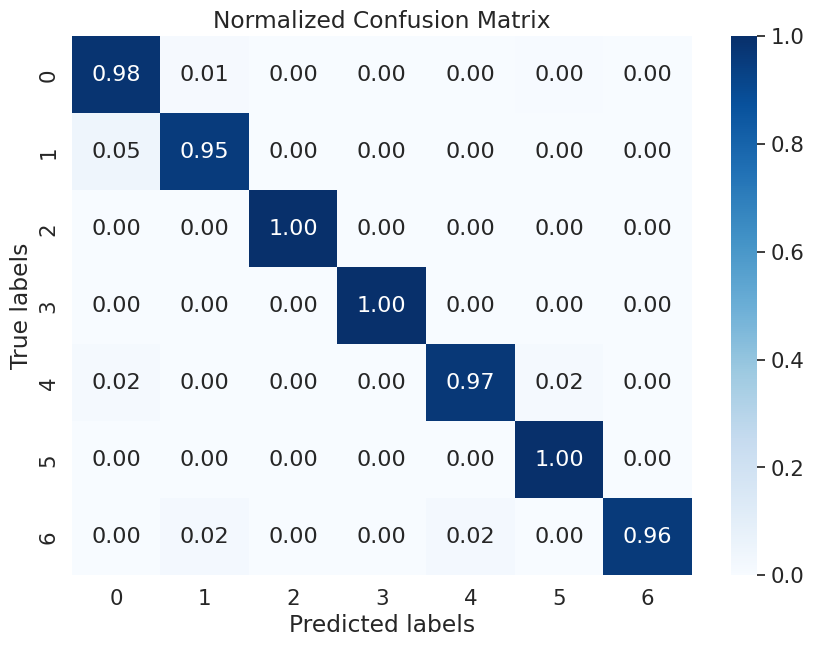

In [28]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def get_predictions_and_labels(model, loader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)  # Ensure images are on the same device as model
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())  # Move predictions to CPU and convert to numpy
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy
    return all_preds, all_labels

# Assuming test_loader is defined and properly set up
predictions, labels = get_predictions_and_labels(model, test_loader)

# Normalizing the confusion matrix by the true (rows) condition
cm = confusion_matrix(labels, predictions, normalize='true')

sns.set(font_scale=1.4)  # for label size
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt=".2f", cmap='Blues')  # font size and format
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.show()